In [1]:
import pandas as pd
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='Araport11_TSS_outward_promoter5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
promoter_bed = f'{location}/FIMO/promoters.bed'
promoter_5UTR_bed = f'{location}/FIMO/promoters_5UTR.bed'
TF_diversity_bed = f'../../../data/output/{file_names}/rolling_window/TF_diversity_rw_{promoter_pref}/{promoter_pref}_TF_diversity.bed'
window_bed = f'../../../data/output/{file_names}/rolling_window/{promoter_pref}_windows.bed'
foldername_prefix = 'TF_diversity_rw'

In [3]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoter_pref}/{promoter_pref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoter_pref}/{promoter_pref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_{promoter_pref}/{promoter_pref}_rootshootintersect_bpcovered_rw.bed'

In [4]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/TF_diversity_rw_{promoter_pref}/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/TF_diversity_rw_Araport11_TSS_outward_promoter5UTR/plots  already exists


In [5]:
#Read in TF_diversity_bed
TF_diversity = pd.read_table(TF_diversity_bed, sep='\t', header=0)

In [6]:
TF_diversity

,name,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count
0,AT1G01010_-1,2.661226,2.353534,7,13,6
1,AT1G01010_-10,-0.000000,-0.000000,1,1,1
2,AT1G01010_-2,1.370951,1.370951,3,5,3
3,AT1G01010_-9,-0.000000,-0.000000,1,1,1
4,AT1G01010_0,2.197160,1.351644,5,9,3
...,...,...,...,...,...,...
330305,AT5G67640_-13,0.000000,0.000000,0,0,0
330306,AT5G67640_-14,0.000000,0.000000,0,0,0
330307,AT5G67640_-15,0.000000,0.000000,0,0,0
330308,AT5G67640_-16,0.000000,0.000000,0,0,0


In [7]:
#Read in windows_bed
windows_df = pd.read_table(window_bed, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name']
windows_df.columns = cols
#merge windows bed with TF_diversity
TF_diversity = pd.merge(windows_df,TF_diversity, how='left', on='name')
#turn NaN into 0s
TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']] = TF_diversity[["Shannon_diversity_TF",'Shannon_diversity_TF_family', 'unique_TF_count', 'total_TF_count','TF_family_count']].fillna(0)
#Make AGI column
TF_diversity['AGI'] = TF_diversity.name.str.split('_',expand=True)[0]
#make window number column
TF_diversity['window_number'] = TF_diversity.name.str.split('_',expand=True)[1]
#make df columns integars
TF_diversity = TF_diversity.astype({'stop':'int','start':'int','chr':'int','Shannon_diversity_TF':'int','Shannon_diversity_TF_family':'int', 'unique_TF_count':'int', 'total_TF_count':'int','TF_family_count':'int'})
#add window length column
TF_diversity = TF_diversity.assign(window_length=TF_diversity.stop - TF_diversity.start)

In [8]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("white")

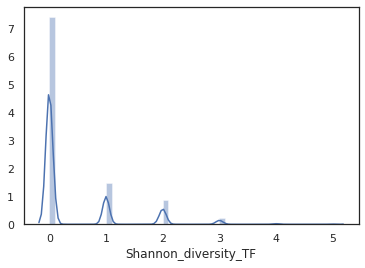

In [9]:
dist_plot = TF_diversity['Shannon_diversity_TF']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [10]:
#remove windows with fewer than 100 promoters extending to that location
TF_diversity = TF_diversity[TF_diversity['window_number'].map(TF_diversity['window_number'].value_counts()) > 99]

In [11]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [12]:
def rep_sample(df, col, n, random_state):
    """function to return a df with equal sample sizes
    taken from here: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe"""
    #identify number of categories
    nu = df[col].nunique()
    # find number of rows
    m = len(df)
    # integar divide total sample size by number of categories
    mpb = n // nu
    # multiply this by the number of categories and subtract from the number of samples to find the remainder
    mku = n - mpb * nu
    # make an array fileld with zeros corresponding to each category
    fills = np.zeros(nu)

    # make values in the array 1s up until the remainder
    fills[:mku] = 1

    # calculate sample sizes for each category
    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)

    #group the df by categories
    gb = df.groupby(col)
    #define sample size function
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], random_state = random_state)
    #run sample size function on each category
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    #return concatenated sub dfs
    return pd.concat(subs)

In [13]:
def windows_coords(output_prefix,variable_of_interest,variable_of_interest_name,variable_of_interest_df,promoter_bed,promoter_5UTR_bed,
                   window_offset,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='median',ci=95, n_boot=10000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distributio, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    promoter_5UTR_df = pd.read_table(promoter_5UTR_bed, sep='\t', header=None)
    promoter_5UTR_df.columns = col
    #add promoter length column
    promoter_df['promoter_length'] = promoter_df.stop-promoter_df.start
    #temporarily merge promoter_df with promoter_5UTR_bed
    temp_merged = pd.merge(promoter_df,promoter_5UTR_df,how='left',on='AGI', suffixes = ('','_promsUTR'))
    #add 5UTR length column
    temp_merged['five_UTR_length'] = (temp_merged.stop_promsUTR-temp_merged.start_promsUTR) - temp_merged.promoter_length
    #filter columns
    temp_merged = temp_merged[['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes','promoter_length','five_UTR_length']]
    #rename temp_merged back to promoter_df
    promoter_df = temp_merged.copy()
    #merge promoter_df with variable_of_interest_df on AGI
    merged = pd.merge(variable_of_interest_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #remove NaN
    merged = merged[merged[variable_of_interest].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window using the Araport TSS (end of promoter bed file) as a reference
    #this will lead to positive positions being in the 5'UTR and negative in the promoter region
    
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #make window number an integar
    variable_of_interest_df = variable_of_interest_df.astype({'window_number': 'float'})
    
    #calculate promoter and 5UTR window length based on window cutoff
    number_of_windows = len(variable_of_interest_df.window_number.unique())
    #promoter window number plus 1 because window 0 is excluded
    promoter_window_number = len(variable_of_interest_df[variable_of_interest_df.window_number < 0].window_number.unique()) + 1
    #5UTR window number plus 1
    five_UTR_window_number = len(variable_of_interest_df[variable_of_interest_df.window_number > 0].window_number.unique()) + 1
    

    #max_promoter_length
    window_length = variable_of_interest_df.window_length.max()
    max_promoter_length = promoter_window_number*(window_length-window_offset)
    max_5UTR_length = five_UTR_window_number*(window_length-window_offset)

    #make integars
    merged2 = merged2.astype({f'{variable_of_interest}':'float64',f'{chromatin_tissue_variable}':'float64'})


    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 2

    f, axes = plt.subplots(subplots, figsize=(10,8))
    OpenChromplot = axes[subplots-subplots]
    variableofinterestplot = axes[subplots-(subplots-1)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None

    try:
        variableofinterestplot
    except NameError:
        variableofinterestplot = None
        
    if genetype!=False:

        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #make integars
        merged2 = merged2.astype({'window_number':'float64'})
        #remove windows with fewer than 50 promoters extending to that location if looking at specific genetypes
        merged2 = merged2[merged2['window_number'].map(merged2['window_number'].value_counts()) > 49]
        #calculate promoter and 5UTR window length based on window cutoff
        number_of_windows = len(merged2.window_number.unique())
        #promoter window number plus 1 because window 0 is excluded
        promoter_window_number = len(merged2[merged2.window_number < 0].window_number.unique()) + 1
        #5UTR window number plus 1
        five_UTR_window_number = len(merged2[merged2.window_number > 0].window_number.unique()) + 1
        
        
        #redefine max_promoter_length
        window_length = merged2.window_length.max()
        max_promoter_length = promoter_window_number*(window_length-window_offset)
        max_5UTR_length = five_UTR_window_number*(window_length-window_offset)
        
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['promoter_length','position']] = -merged2[['promoter_length','position']]
    

    if genetype==False:
        

        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'A: All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])  

        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest], x=merged2.position, ax=variableofinterestplot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'B: All promoters sliding windows {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position relative to Araport 11 TSS')

               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'A: {genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([]) 
            


        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position,
                         ax=variableofinterestplot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'B: {genetype} {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position relative to Araport 11 TSS')
        

    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal
        # first select only the relevant genetypes
        merged2 = merged2[merged2.gene_type.isin([genetype,genetype2])]
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        
        
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            #set titles & axes names
            OpenChromplot.set_title(f'A: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])

        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterestplot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterestplot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterestplot.set_title(f'B: {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position relative to Araport 11 TSS')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal    
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        
        
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
            OpenChromplot.set_title(f'A: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])          
    
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterestplot, label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterestplot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest], x=merged2[merged2.gene_type == genetype3].position, 
                            ax=variableofinterestplot,label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterestplot.set_title(f'B: {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position relative to Araport 11 TSS')
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
    #set x axis range if specified    
    if x_range==False:
        x_range_final = [-max_promoter_length, max_5UTR_length]

    else:
        x_range_final = x_range
        
    #for all subplots:
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim(x_range_final)
    #use a tight layout
    f.tight_layout()
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoter_pref}/plots/{output_prefix}_{estimator}_openchromatin_sliding_window.pdf', format='pdf')
    return merged2

In [14]:
def plot_length(df,output_prefix,foldername_prefix, genetype=False, genetype2=False, genetype3=False):
    ###NEED TO SHARE AXES!
    """function to plot length distribution of promoters and 5'UTRs"""
    #make columns integar
    #df = df.astype({'promoter_length': 'int','five_UTR_length':'int'})
    #make promoter length positive (square then take square root)
    df.promoter_length = (df.promoter_length**2)**(1/2)
    #make integar
    #make subplots
    subplots = 2

    f, axes = plt.subplots(subplots, figsize=(10,8))
    promoterlengths = axes[subplots-subplots]
    fiveUTRlengths = axes[subplots-(subplots-1)]
    #find max length
    max_prom_length = df.promoter_length.max()
    max_5UTR_length = df.five_UTR_length.max()
    #choose the largest value
    x_range = max(max_prom_length, max_5UTR_length)
    
    
    
    if genetype==False:
        #prom length plot
        sns.distplot(df.promoter_length, ax=promoterlengths)
        #5'UTR length plot
        sns.distplot(df.five_UTR_length, ax=fiveUTRlengths,axlabel='length (bp)')
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])

    elif genetype2==False:
        #prom length plot
        sns.distplot(df[df.gene_type == genetype].promoter_length, ax=promoterlengths)
        #5'UTR length plot
        sns.distplot(df[df.gene_type == genetype].five_UTR_length, ax=fiveUTRlengths,axlabel='length (bp)')
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        
    elif genetype3==False:
        #prom length plots
        sns.distplot(df[df.gene_type == genetype].promoter_length, hist=None,ax=promoterlengths,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].promoter_length, hist=None,ax=promoterlengths,label=genetype2)
        #5'UTR length plots
        sns.distplot(df[df.gene_type == genetype].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype)
        sns.distplot(df[df.gene_type == genetype2].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype2)
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        plt.legend()
        
        
        
        
        
    else:
        #prom length plots
        sns.distplot(df[df.gene_type == genetype].promoter_length, hist=None,ax=promoterlengths,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].promoter_length, hist=None,ax=promoterlengths,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].promoter_length, hist=None,ax=promoterlengths,label=genetype3)
        #5'UTR length plots
        sns.distplot(df[df.gene_type == genetype].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype)
        sns.distplot(df[df.gene_type == genetype2].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].five_UTR_length,hist=None, ax=fiveUTRlengths,axlabel='length (bp)',label=genetype3)
        #set titles
        promoterlengths.set_title('A: promoter lengths using Araport11 TSS annotation')
        fiveUTRlengths.set_title('B: 5\'UTR lengths using Araport11 TSS annotation')
        #set y label
        promoterlengths.set_ylabel('Density')
        fiveUTRlengths.set_ylabel('Density')
        #remove x labels from the top graph
        promoterlengths.set_xlabel('')
        promoterlengths.set_xticklabels([])
        plt.legend()
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim(0,x_range)
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_{promoter_pref}/plots/{output_prefix}_promoter_lengths.pdf', format='pdf')
        

In [15]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [16]:
#add root chromatin coverage data
TF_diversity = add_coverage(TF_diversity, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
TF_diversity = add_coverage(TF_diversity, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
TF_diversity = add_coverage(TF_diversity, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

In [17]:
TF_diversity

,chr,start,stop,name,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,AGI,window_number,window_length,name_root_chrom,percentage_bases_covered,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,1,2630,2730,AT1G01010_-19,0,0,0,0,0,AT1G01010,-19,100,AT1G01010_-19,100.0,AT1G01010_-19,100.0,AT1G01010_-19,100.0
1,1,2680,2780,AT1G01010_-18,0,0,0,0,0,AT1G01010,-18,100,AT1G01010_-18,100.0,AT1G01010_-18,100.0,AT1G01010_-18,100.0
2,1,2730,2830,AT1G01010_-17,0,0,0,0,0,AT1G01010,-17,100,AT1G01010_-17,100.0,AT1G01010_-17,100.0,AT1G01010_-17,100.0
3,1,2780,2880,AT1G01010_-16,0,0,0,0,0,AT1G01010,-16,100,AT1G01010_-16,100.0,AT1G01010_-16,100.0,AT1G01010_-16,100.0
4,1,2830,2930,AT1G01010_-15,0,0,0,0,0,AT1G01010,-15,100,AT1G01010_-15,100.0,AT1G01010_-15,97.0,AT1G01010_-15,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353309,5,26971368,26971468,AT5G67640_-15,0,0,0,0,0,AT5G67640,-15,100,AT5G67640_-15,24.0,AT5G67640_-15,0.0,AT5G67640_-15,0.0
353310,5,26971418,26971518,AT5G67640_-16,0,0,0,0,0,AT5G67640,-16,100,AT5G67640_-16,0.0,AT5G67640_-16,0.0,AT5G67640_-16,0.0
353311,5,26971468,26971568,AT5G67640_-17,1,0,2,2,1,AT5G67640,-17,100,AT5G67640_-17,0.0,AT5G67640_-17,0.0,AT5G67640_-17,0.0
353312,5,26971518,26971618,AT5G67640_-18,1,0,2,2,1,AT5G67640,-18,100,AT5G67640_-18,0.0,AT5G67640_-18,0.0,AT5G67640_-18,0.0


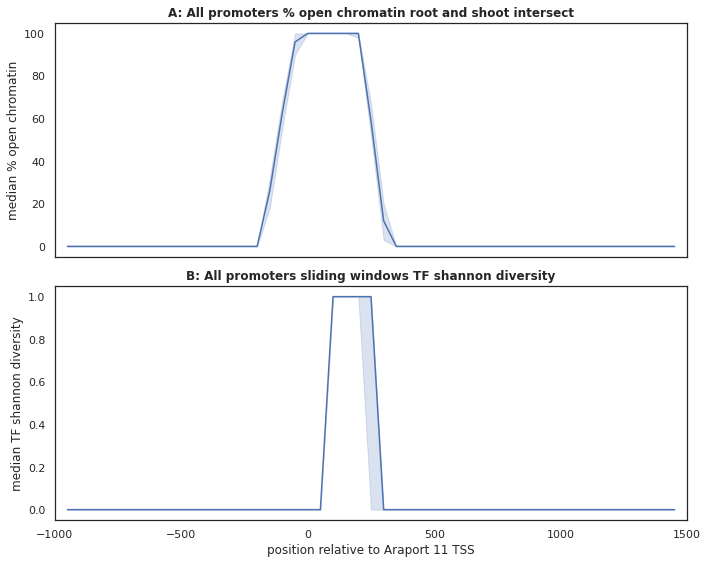

In [18]:
#all promoters in genome
all_proms = windows_coords('Araport11_allproms','Shannon_diversity_TF','TF shannon diversity',TF_diversity,promoter_bed,promoter_5UTR_bed,50,estimator='median')

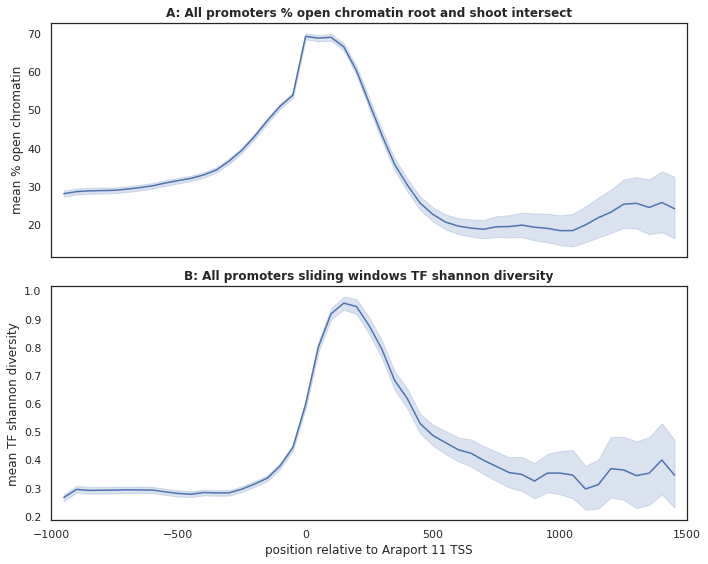

In [19]:
#all promoters in genome
all_proms = windows_coords('Araport11_allproms','Shannon_diversity_TF','TF shannon diversity',TF_diversity,promoter_bed,promoter_5UTR_bed,50,estimator='mean')

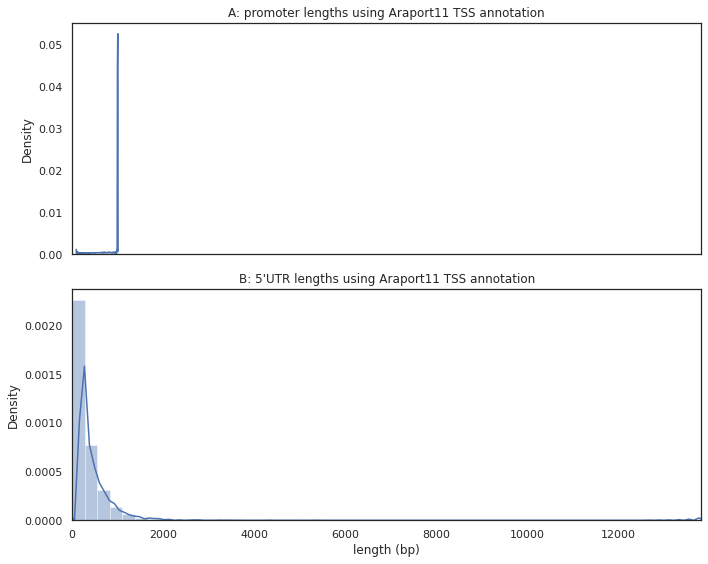

In [20]:
plot_length(all_proms,'Araport11_allproms','TF_diversity_rw')

## Now do constitutive and variable promoter from Czechowski et al 2005

In [21]:
TF_diversity_prom_types = add_genetype(TF_diversity, Czechowski_gene_categories)

sample size in each category = 100


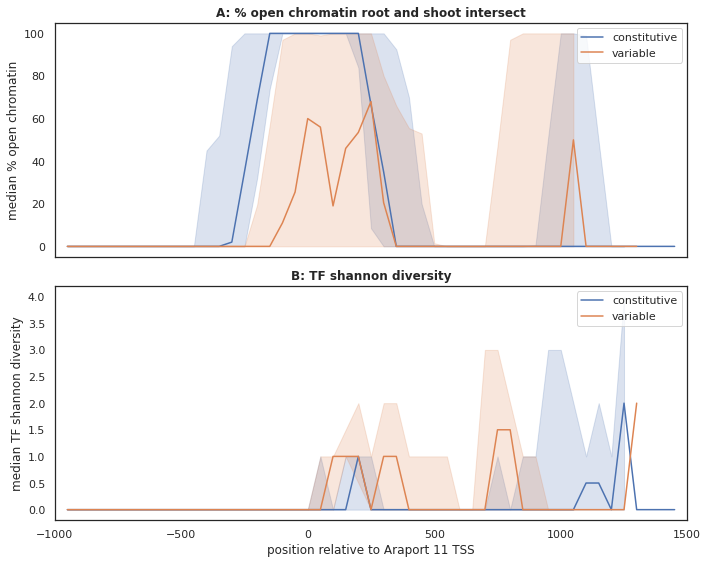

In [22]:
rolling_rootshootintersect = windows_coords('Araport11_Czechowski_genetypenocontrol','Shannon_diversity_TF','TF shannon diversity',
                                            TF_diversity_prom_types,promoter_bed,promoter_5UTR_bed,
                         50,estimator='median',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

sample size in each category = 100


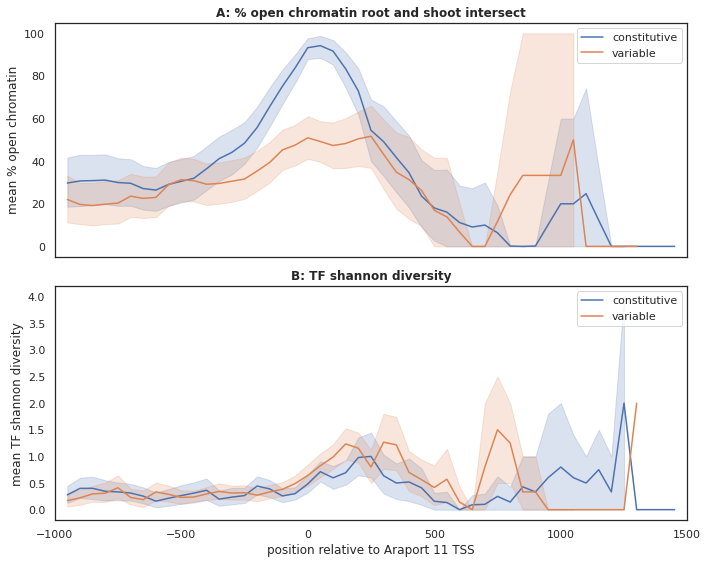

In [23]:
rolling_rootshootintersect = windows_coords('Araport11_Czechowski_genetypenocontrol','Shannon_diversity_TF','TF shannon diversity',
                                            TF_diversity_prom_types,promoter_bed,promoter_5UTR_bed,
                         50,estimator='mean',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

In [24]:
TF_diversity_types_length = add_genetype(all_proms, Czechowski_gene_categories)

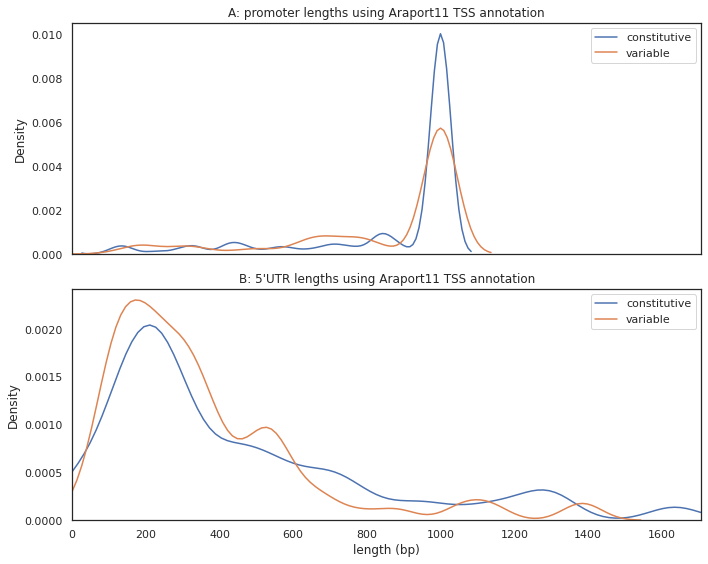

In [25]:
plot_length(TF_diversity_types_length,'Araport11_Czechowski_genetypenocontrol','TF_diversity_rw', genetype='constitutive', genetype2='variable')

sample size in each category = 100


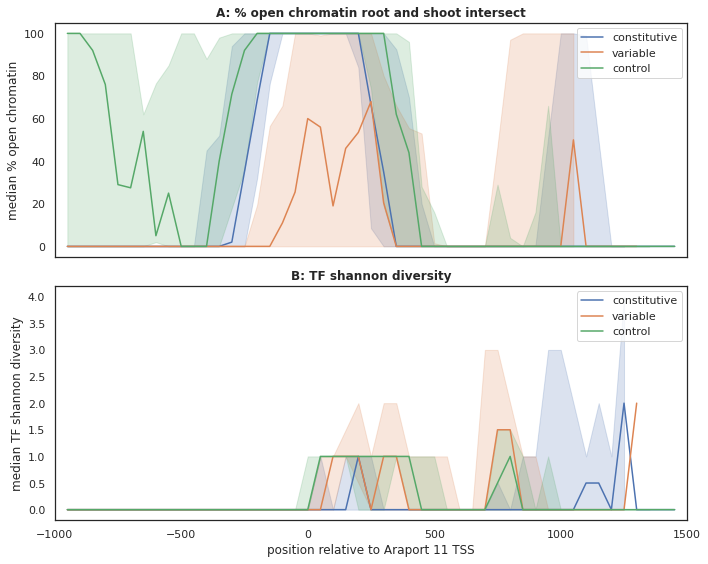

In [26]:
rolling_incl_control = windows_coords('Araport11_Czechowski_genetype','Shannon_diversity_TF','TF shannon diversity',TF_diversity_prom_types,
                                      promoter_bed,promoter_5UTR_bed, 50,estimator='median',
                                      genetype='constitutive', genetype2='variable', genetype3='control',ci=95, n_boot=10000)

sample size in each category = 100


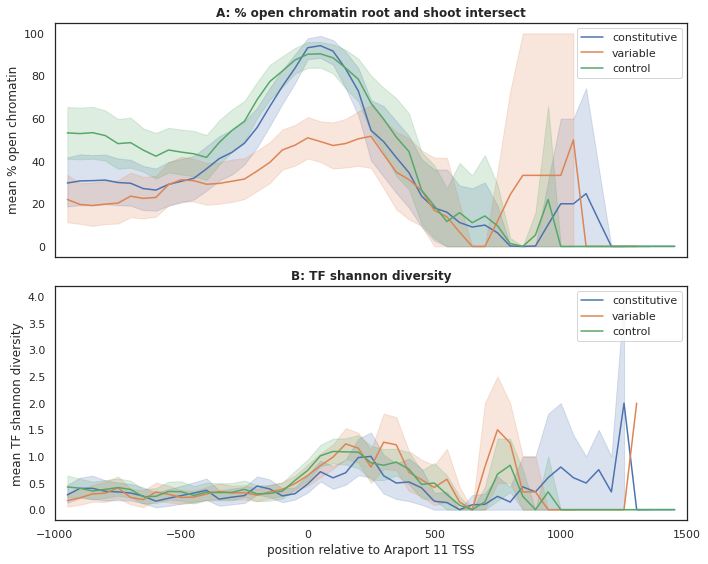

In [27]:
rolling_incl_control = windows_coords('Araport11_Czechowski_genetype','Shannon_diversity_TF','TF shannon diversity',TF_diversity_prom_types,
                                      promoter_bed,promoter_5UTR_bed, 50,estimator='mean',
                                      genetype='constitutive', genetype2='variable', genetype3='control',ci=95, n_boot=10000)

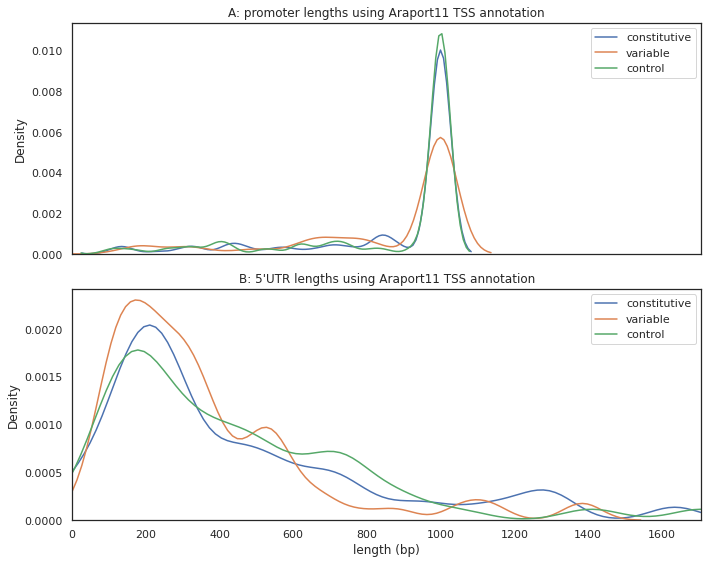

In [28]:
plot_length(TF_diversity_types_length,'Araport11_Czechowski_genetype','TF_diversity_rw',genetype='constitutive', genetype2='variable', genetype3='control')